In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os, glob, re, datetime

In [60]:
unit_test_regex = re.compile('Testing \[(\w*)\]\s*(Ok|Failed)')

def parse_unit_log(filename):
    results = {}
    with open(filename) as fh:
        for line in fh:
            match = unit_test_regex.search(line)
            if match:
                results[match.group(1)] = (match.group(2) == 'Ok')
    return results

In [61]:
app_test_regex = re.compile('Testing \[(\w*)\]')
app_test_case_regex = re.compile('(OK|Failed) ... Case \[(\w*)\]')

def parse_app_log(filename):
    results = {}
    with open(filename) as fh:
        for line in fh:
            app_match = app_test_regex.search(line)
            if app_match:
                current_app = app_match.group(1)
            case_match = app_test_case_regex.search(line)
            if case_match:
                results['{}_{}'.format(current_app, case_match.group(2))] = (case_match.group(1) == 'OK')
    return results

In [62]:
cat_package_regex = re.compile('Working on Package \[(\w*)\]')
cat_test_regex = re.compile('(OK|Failed) ... Case \[(\w*)\]')

def parse_cat_log(filename):
    results = {}
    with open(filename) as fh:
        for line in fh:
            package_match = cat_package_regex.search(line)
            if package_match:
                current_package = package_match.group(1)
            test_match = cat_test_regex.search(line)
            if test_match:
                results['{}_{}'.format(current_package, test_match.group(2))] = (test_match.group(1) == 'OK')
    return results

In [56]:
date_regex = re.compile('Test(\d{4})-(\d{2})-(\d{2}).log')

def get_date(filename):
    match = date_regex.search(filename)
    if match:
        return datetime.date(int(match.group(1)), int(match.group(2)), int(match.group(3)))

In [70]:
app_test_glob = "appTest*.log"
cat_test_glob = "catTest*.log"
unit_test_glob = "unitTest*.log"

def get_test_data_frames(directory):
    app_test_logs = glob.glob(os.path.join(directory, app_test_glob))
    cat_logs = glob.glob(os.path.join(directory, cat_test_glob))
    unit_logs = glob.glob(os.path.join(directory, unit_test_glob))
    
    app_results = {}
    for log_file in app_test_logs:
        app_results[get_date(log_file)] = parse_app_log(log_file)
    app_df = pd.DataFrame.from_dict(app_results)
    
    cat_results = {}
    for log_file in cat_logs:
        cat_results[get_date(log_file)] = parse_cat_log(log_file)
    cat_df = pd.DataFrame.from_dict(cat_results)
        
    unit_results = {}
    for log_file in unit_logs:
        unit_results[get_date(log_file)] = parse_unit_log(log_file)
    unit_df = pd.DataFrame.from_dict(unit_results)
    
    return app_df, cat_df, unit_df

In [87]:
def compute_failure_frequencies(df):
    return (df==False).sum(axis=1) / df.count(axis=1)

In [6]:
logs_dir = "/usgs/cpkgs/isis3/logs/builds-tests/"
CentOS7 = "Linux_x86_64_prog24"
Mac10_11 = "Darwin_i386_prog26"

In [71]:
centos_app_df, centos_cat_df, centos_unit_df = get_test_data_frames(os.path.join(logs_dir, CentOS7))

In [93]:
centos_app_failure_frequencies = compute_failure_frequencies(centos_app_df)

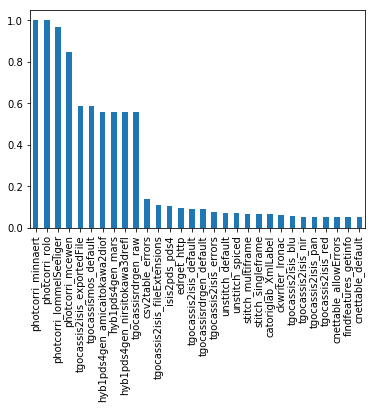

In [101]:
centos_app_failure_frequencies.nlargest(30).plot(kind='bar')